У цьому ДЗ ми потренуємось розв'язувати задачу багатокласової класифікації за допомогою логістичної регресії з використанням стратегій One-vs-Rest та One-vs-One, оцінити якість моделей та порівняти стратегії.

### Опис задачі і даних

**Контекст**

В цьому ДЗ ми працюємо з даними про сегментацію клієнтів.

Сегментація клієнтів – це практика поділу бази клієнтів на групи індивідів, які схожі між собою за певними критеріями, що мають значення для маркетингу, такими як вік, стать, інтереси та звички у витратах.

Компанії, які використовують сегментацію клієнтів, виходять з того, що кожен клієнт є унікальним і що їхні маркетингові зусилля будуть більш ефективними, якщо вони орієнтуватимуться на конкретні, менші групи зі зверненнями, які ці споживачі вважатимуть доречними та які спонукатимуть їх до купівлі. Компанії також сподіваються отримати глибше розуміння уподобань та потреб своїх клієнтів з метою виявлення того, що кожен сегмент цінує найбільше, щоб точніше адаптувати маркетингові матеріали до цього сегменту.

**Зміст**.

Автомобільна компанія планує вийти на нові ринки зі своїми існуючими продуктами (P1, P2, P3, P4 і P5). Після інтенсивного маркетингового дослідження вони дійшли висновку, що поведінка нового ринку схожа на їхній існуючий ринок.

На своєму існуючому ринку команда з продажу класифікувала всіх клієнтів на 4 сегменти (A, B, C, D). Потім вони здійснювали сегментовані звернення та комунікацію з різними сегментами клієнтів. Ця стратегія працювала для них надзвичайно добре. Вони планують використати ту саму стратегію на нових ринках і визначили 2627 нових потенційних клієнтів.

Ви маєте допомогти менеджеру передбачити правильну групу для нових клієнтів.

В цьому ДЗ використовуємо дані `customer_segmentation_train.csv`[скачати дані](https://drive.google.com/file/d/1VU1y2EwaHkVfr5RZ1U4MPWjeflAusK3w/view?usp=sharing). Це `train.csv`з цього [змагання](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data?select=train.csv)

**Завдання 1.** Завантажте та підготуйте датасет до аналізу. Виконайте обробку пропущених значень та необхідне кодування категоріальних ознак. Розбийте на тренувальну і тестувальну вибірку, де в тесті 20%. Памʼятаємо, що весь препроцесинг ліпше все ж тренувати на тренувальній вибірці і на тестувальній лише використовувати вже натреновані трансформери.
Але в даному випадку оскільки значень в категоріях небагато, можна зробити обробку і на оригінальних даних, а потім розбити - це простіше. Можна також реалізувати процесинг і тренування моделі з пайплайнами. Обирайте як вам зручніше.

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC



In [157]:
def process_data(df, target_col=''):
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target_col] if target_col else None)
    input_cols = train_df.drop(columns=[target_col]).columns.tolist()

    train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
    val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()

    numeric_cols = train_inputs.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = train_inputs.select_dtypes(exclude=[np.number]).columns.tolist()

    numeric_transform = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='mean')),
      ('scaler', StandardScaler())
      ])

    categorical_transform = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # create indexes in df non-categorical columns
    numeric_cols_index = [train_inputs.columns.get_loc(col) for col in numeric_cols]
    categorical_cols_index = [train_inputs.columns.get_loc(col) for col in categorical_cols]

    preprocessor = ColumnTransformer(
        transformers=[
          ('num', numeric_transform, numeric_cols),
          ('cat', categorical_transform, categorical_cols)
    ])

    # train_inputs = preprocessor.fit_transform(train_inputs)
    # val_inputs = preprocessor.transform(val_inputs)

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(train_targets)
    y_val_encoded = label_encoder.transform(val_targets)

    return preprocessor, train_inputs, y_train_encoded, val_inputs, y_val_encoded, numeric_cols_index, categorical_cols_index


In [158]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/1nG5b1wNGNkrwQPiNAo6fo0JJBT3IUZiVFDqJPO_wpr0/gviz/tq?tqx=out:csv&sheet=Sheet1', index_col=False)
target_col = 'Segmentation'
preprocessor, train_inputs, y_train_encoded, val_inputs, y_val_encoded, numeric_cols_index, categorical_cols_index = process_data(df, target_col)

Створено функцію process_data яка підготовлює дані до тренування моделі та виведено тренувальний та валідаційний набори даних з відповідними таргетами

**Завдання 2. Важливо уважно прочитати все формулювання цього завдання до кінця!**

Застосуйте методи ресемплингу даних SMOTE та SMOTE-Tomek з бібліотеки imbalanced-learn до тренувальної вибірки. В результаті у Вас має вийти 2 тренувальних набори: з апсемплингом зі SMOTE, та з ресамплингом з SMOTE-Tomek.

Увага! В нашому наборі даних є як категоріальні дані, так і звичайні числові. Базовий SMOTE не буде правильно працювати з категоріальними даними, але є його модифікація, яка буде. Тому в цього завдання є 2 виконання

  1. Застосувати SMOTE базовий лише на НЕкатегоріальних ознаках.

  2. Переглянути інформацію про метод [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) і використати цей метод в цій задачі. За цей спосіб буде +3 бали за це завдання і він рекомендований для виконання.

  **Підказка**: аби скористатись SMOTENC треба створити змінну, яка містить індекси ознак, які є категоріальними (їх номер серед колонок) і передати при ініціації екземпляра класу `SMOTENC(..., categorical_features=cat_feature_indeces)`.
  
  Ви також можете розглянути варіант використання варіації SMOTE, який працює ЛИШЕ з категоріальними ознаками [SMOTEN](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTEN.html)

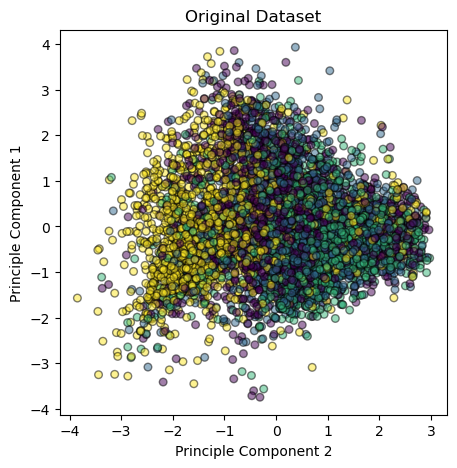

In [159]:
# Function for plotting dataset
def plot_data(X, y, ax, title):
    ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, s = 30, edgecolor=(0,0,0,0.5))
    ax.set_ylabel('Principle Component 1')
    ax.set_xlabel('Principle Component 2')
    if title is not None:
        ax.set_title(title)

train_inputs_proc = preprocessor.fit_transform(train_inputs)
val_inputs_proc = preprocessor.transform(val_inputs)

pca = PCA()
pca.fit(train_inputs_proc)
X_train_pca = pca.transform(train_inputs_proc)
X_test_pca = pca.transform(val_inputs_proc)

# Plot dataset
fig,ax = plt.subplots(figsize=(5, 5))
plot_data(X_train_pca, y_train_encoded, ax, title='Original Dataset')

In [160]:
# SMOTE
X_train_non_categorical = train_inputs_proc[:, numeric_cols_index]
X_test_non_categorical = val_inputs_proc[:, numeric_cols_index]

smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train_non_categorical, y_train_encoded)


In [161]:
# SMOTENC
from imblearn.over_sampling import SMOTENC
smotenc = SMOTENC(categorical_features=categorical_cols_index, random_state=0)
X_train_smotenc, y_train_smotenc = smotenc.fit_resample(train_inputs_proc, y_train_encoded)



In [162]:
# Smote-Tomek
from imblearn.combine import SMOTETomek
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

smote_tomek = SMOTETomek(random_state=0)
X_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(train_inputs_proc, y_train_encoded)


**Завдання 3**.
  1. Навчіть модель логістичної регресії з використанням стратегії One-vs-Rest з логістичною регресією на оригінальних даних, збалансованих з SMOTE, збалансованих з Smote-Tomek.  
  2. Виміряйте якість кожної з натренованих моделей використовуючи `sklearn.metrics.classification_report`.
  3. Напишіть, яку метрику ви обрали для порівняння моделей.
  4. Яка модель найкраща?
  5. Якщо немає суттєвої різниці між моделями - напишіть свою гіпотезу, чому?

In [163]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

def train_and_evaluate(X_train, y_train, X_val, y_val, title = ''):
    model = LogisticRegression(solver='liblinear')
    ovr_model = OneVsRestClassifier(model)
    ovr_model.fit(X_train, y_train)

    ovr_predictions = ovr_model.predict(X_val)
    print(f'{title}:\n {classification_report(y_val, ovr_predictions)}')

    fig, ax = plt.subplots(figsize=(5, 5))
    plot_data(X_train, y_train, ax, title=f'Train Data {title}')



Original:
               precision    recall  f1-score   support

           0       0.42      0.47      0.44       394
           1       0.40      0.16      0.23       372
           2       0.49      0.62      0.54       394
           3       0.65      0.76      0.70       454

    accuracy                           0.52      1614
   macro avg       0.49      0.50      0.48      1614
weighted avg       0.50      0.52      0.49      1614

SMOTE:
               precision    recall  f1-score   support

           0       0.36      0.32      0.34       394
           1       0.22      0.05      0.08       372
           2       0.45      0.66      0.54       394
           3       0.53      0.72      0.61       454

    accuracy                           0.45      1614
   macro avg       0.39      0.44      0.39      1614
weighted avg       0.40      0.45      0.41      1614



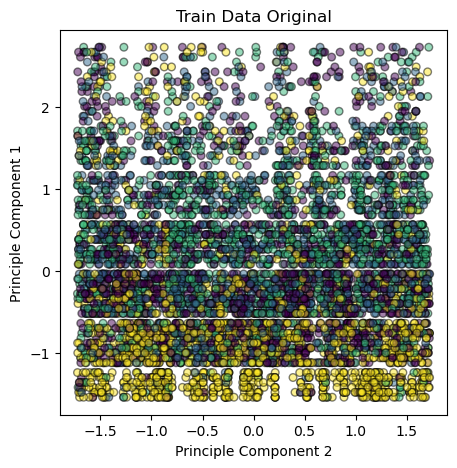

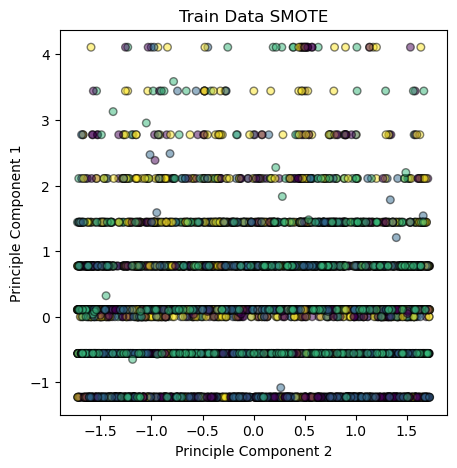

In [164]:
train_and_evaluate(train_inputs_proc, y_train_encoded, val_inputs_proc, y_val_encoded, title='Original')
train_and_evaluate(X_train_smote, y_train_smote, X_test_non_categorical, y_val_encoded, title='SMOTE')

SMOTENC:
               precision    recall  f1-score   support

           0       0.41      0.48      0.44       394
           1       0.37      0.22      0.27       372
           2       0.49      0.57      0.53       394
           3       0.67      0.71      0.69       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.49      1614
weighted avg       0.50      0.51      0.50      1614

SMOTE-Tomek:
               precision    recall  f1-score   support

           0       0.41      0.48      0.45       394
           1       0.37      0.23      0.28       372
           2       0.49      0.57      0.53       394
           3       0.68      0.70      0.69       454

    accuracy                           0.50      1614
   macro avg       0.49      0.49      0.49      1614
weighted avg       0.50      0.50      0.50      1614



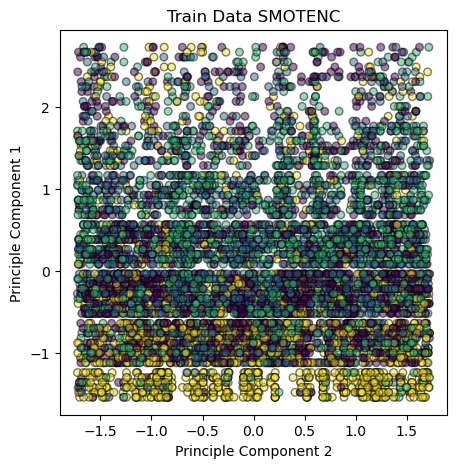

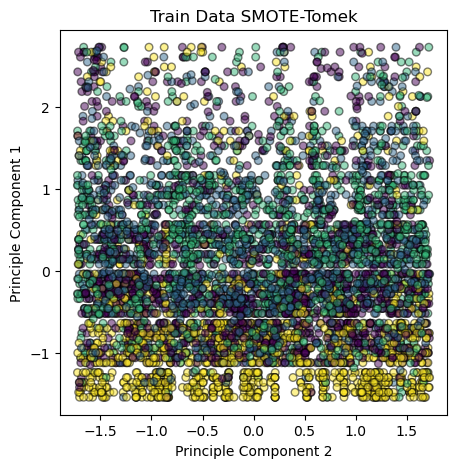

In [165]:
train_and_evaluate(X_train_smotenc, y_train_smotenc, val_inputs_proc, y_val_encoded, title='SMOTENC')
train_and_evaluate(X_train_smote_tomek, y_train_smote_tomek, val_inputs_proc, y_val_encoded, title='SMOTE-Tomek')

Висновок:

- SMOTENC — Найкраща модель, вона забезпечує найвищу F1-метрику на мінорних класах, не втрачаючи точності на важлвих класах.
- SMOTE виявився неефективним через те що ігнорувались категоріальні ознаки і включались лише числові що лише погіршило результати для неважливих класів.
- SMOTE-Tomek показав себе добре, очищаючи точки після апсемплінгу, однак не перевершив SMOTE.
- Тільки macro F1-score однаково оцінює усі класи незалежно від їхньої кількості прикладів, тому важливо брати до уваги її значення.
- Різниця між моделями незначна, і причина цього, ймовірно, в обмеженості самої моделі (логістична регресія) та якості вхідних ознак
